In [1]:
# Import potential libraries to use

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from numpy import log

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
model_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/modelling_data.csv")
model_df.head()

,date,UV000005502,UV000005507,UV000005522,UV000065501,UV000065516,UVM00065503,UVM00065510,UVM00065518,IV000005557,...,SGM00061695,SGM00061697,SGM00061698,SGM00061699,SL000061856,LIM00065660,GHM00065472,CVM00008594,GV000001832,avg_temp
0,1980-01-01,23.89,24.44,26.67,21.67,24.44,23.33,24.44,26.67,25.56,...,23.33,26.67,28.89,30.00,26.67,27.78,26.11,21.67,26.11,24.630000
1,1980-01-02,24.44,24.44,27.22,24.44,26.11,25.00,26.11,26.67,25.56,...,24.44,26.67,27.78,26.11,26.67,27.78,28.89,22.22,26.11,25.208750
2,1980-01-03,24.44,25.00,26.11,22.78,25.00,25.56,25.00,26.67,26.11,...,23.33,26.67,28.89,27.78,26.67,27.78,28.89,21.11,26.11,25.409583
3,1980-01-04,23.33,25.00,26.11,23.33,24.44,24.44,25.00,26.67,26.67,...,21.67,26.67,23.33,28.33,26.67,27.78,28.89,21.67,26.11,25.547778
4,1980-01-05,23.89,25.56,27.22,23.89,25.56,25.56,26.67,26.67,26.11,...,24.44,26.67,23.33,27.22,26.67,27.78,28.89,21.67,26.11,25.339583


In [3]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15706 entries, 0 to 15705
Data columns (total 74 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         15706 non-null  object 
 1   UV000005502  15706 non-null  float64
 2   UV000005507  15706 non-null  float64
 3   UV000005522  15706 non-null  float64
 4   UV000065501  15706 non-null  float64
 5   UV000065516  15706 non-null  float64
 6   UVM00065503  15706 non-null  float64
 7   UVM00065510  15706 non-null  float64
 8   UVM00065518  15706 non-null  float64
 9   IV000005557  15706 non-null  float64
 10  IV000005562  15706 non-null  float64
 11  IV000005592  15706 non-null  float64
 12  IV000065585  15706 non-null  float64
 13  IV000065599  15706 non-null  float64
 14  IVM00065545  15706 non-null  float64
 15  IVM00065560  15706 non-null  float64
 16  IVM00065563  15706 non-null  float64
 17  IVM00065578  15706 non-null  float64
 18  IVM00065594  15706 non-null  float64
 19  NG00

In [4]:
# Convert the date to datetime

model_df["date"] = pd.to_datetime(model_df["date"], errors='coerce')

# Set the date as index
model_df = model_df.set_index('date')

# COnvert datetime to GMT+1
model_df.index = model_df.index.tz_localize("UTC").tz_convert("Africa/Kinshasa")

model_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15706 entries, 1980-01-01 01:00:00+01:00 to 2022-12-31 01:00:00+01:00
Data columns (total 73 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UV000005502  15706 non-null  float64
 1   UV000005507  15706 non-null  float64
 2   UV000005522  15706 non-null  float64
 3   UV000065501  15706 non-null  float64
 4   UV000065516  15706 non-null  float64
 5   UVM00065503  15706 non-null  float64
 6   UVM00065510  15706 non-null  float64
 7   UVM00065518  15706 non-null  float64
 8   IV000005557  15706 non-null  float64
 9   IV000005562  15706 non-null  float64
 10  IV000005592  15706 non-null  float64
 11  IV000065585  15706 non-null  float64
 12  IV000065599  15706 non-null  float64
 13  IVM00065545  15706 non-null  float64
 14  IVM00065560  15706 non-null  float64
 15  IVM00065563  15706 non-null  float64
 16  IVM00065578  15706 non-null  float64
 17  IVM00065594  15706 non-null  float64
 18 

In [5]:
model_df.isnull().sum()

UV000005502    0
UV000005507    0
UV000005522    0
UV000065501    0
UV000065516    0
              ..
LIM00065660    0
GHM00065472    0
CVM00008594    0
GV000001832    0
avg_temp       0
Length: 73, dtype: int64

In [6]:
model_df.columns

Index(['UV000005502', 'UV000005507', 'UV000005522', 'UV000065501',
       'UV000065516', 'UVM00065503', 'UVM00065510', 'UVM00065518',
       'IV000005557', 'IV000005562', 'IV000005592', 'IV000065585',
       'IV000065599', 'IVM00065545', 'IVM00065560', 'IVM00065563',
       'IVM00065578', 'IVM00065594', 'NG000001036', 'NG000001049',
       'NG000001052', 'NG000001075', 'NG000001080', 'NG000001090',
       'NG000061017', 'NG000061024', 'NG000061043', 'NG000061096',
       'NGM00061045', 'NGM00061091', 'NGM00061099', 'UVM00065505',
       'TO000005361', 'TO000005376', 'TOM00065352', 'TOM00065355',
       'TOM00065387', 'GAM00061701', 'ML000061297', 'MLM00061230',
       'MLM00061257', 'MLM00061265', 'MLM00061272', 'MLM00061277',
       'MLM00061291', 'MLM00061293', 'MLM00061296', 'PUM00061766',
       'BN000005319', 'BN000005344', 'BN000065306', 'BN000065335',
       'BNM00065330', 'BNM00065338', 'NIM00065201', 'SG000001627',
       'SG000061612', 'SG000061641', 'SG000061687', 'SGM000616

Creating a model with one of the stations

In [7]:
y = model_df['UV000005502']
y.head()

date
1980-01-01 01:00:00+01:00    23.89
1980-01-02 01:00:00+01:00    24.44
1980-01-03 01:00:00+01:00    24.44
1980-01-04 01:00:00+01:00    23.33
1980-01-05 01:00:00+01:00    23.89
Name: UV000005502, dtype: float64

<Axes: xlabel='date'>

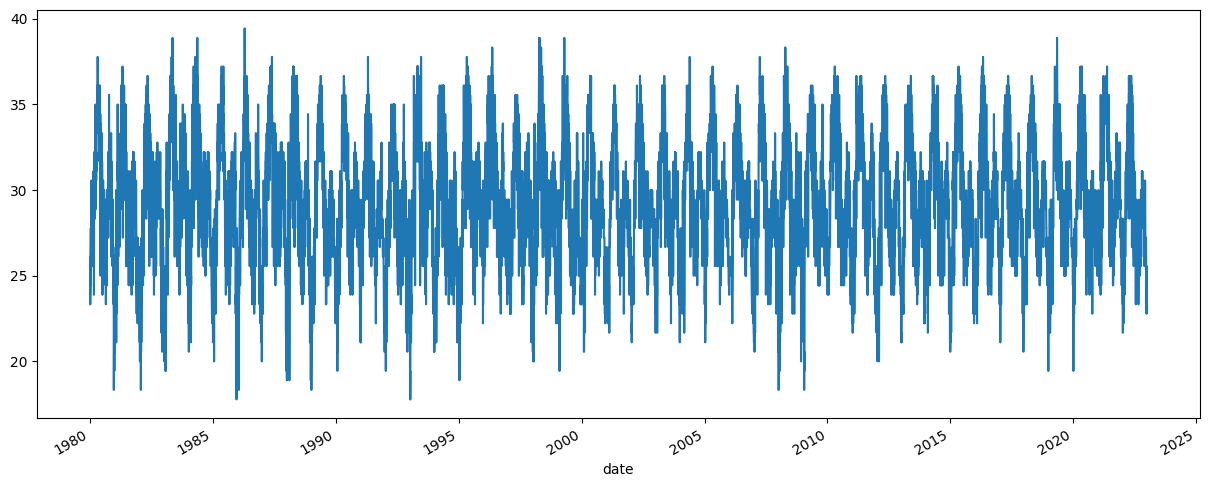

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

y.plot(ax=ax)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

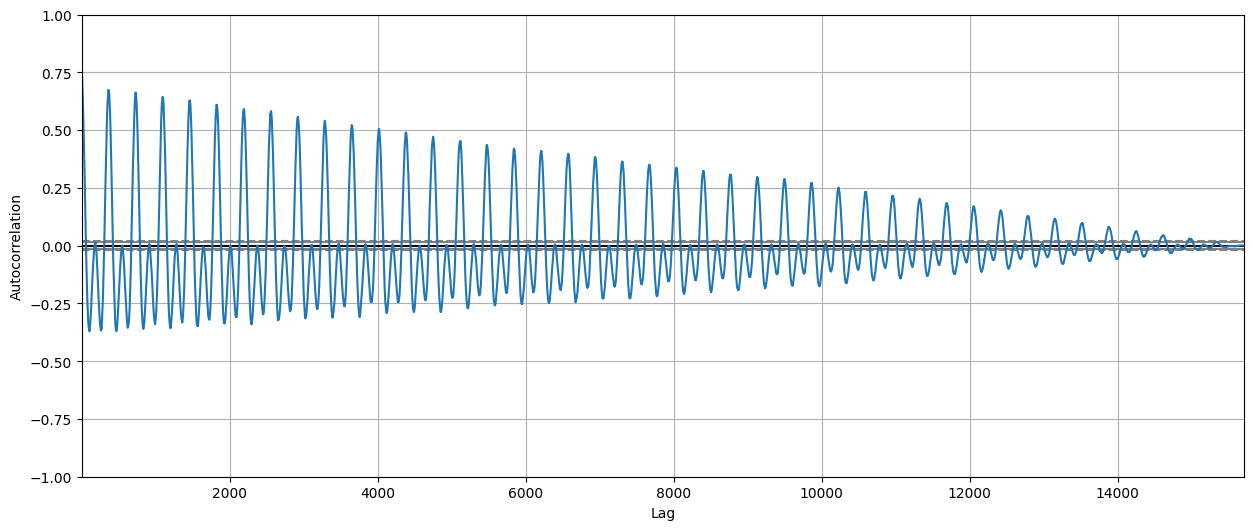

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

autocorrelation_plot(y)

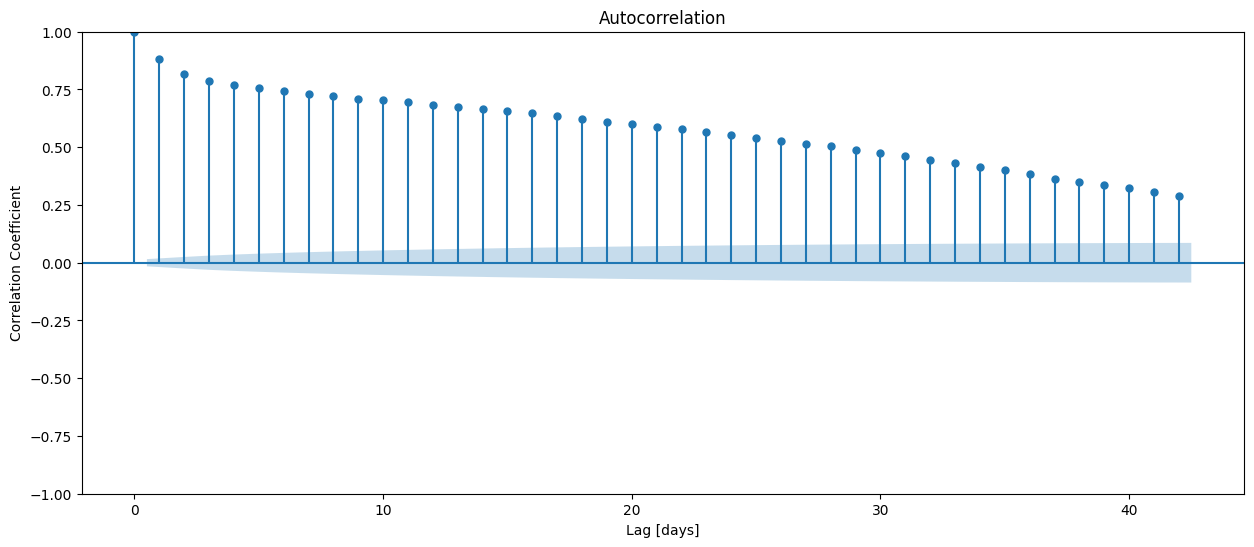

In [10]:
# ACF Plot

fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

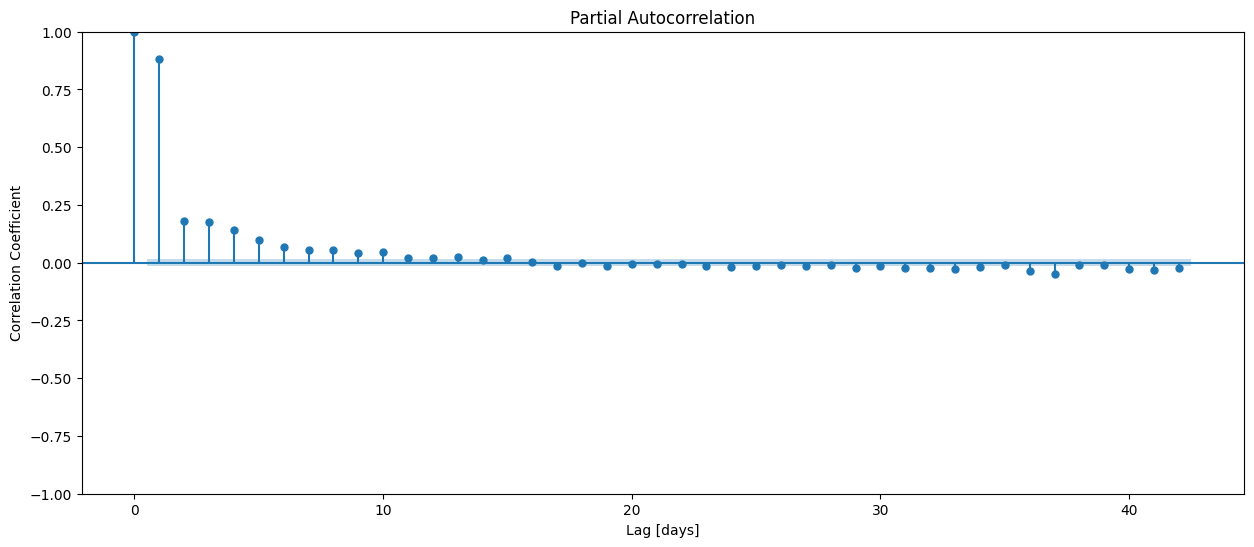

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [12]:
print(y.index.min(), y.index.max())

1980-01-01 01:00:00+01:00 2022-12-31 01:00:00+01:00


In [13]:
y.index.shape

(15706,)

In [14]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.608482
p-value: 0.000000


Since p-value(0.00) is less than the significance level (p_value = 0.05) then we reject the null hypothesis and infer that the time series is indeed stationary. The null hypothesis (Ho) of the ADF test is that the time series is non-stationary.

So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

If P Value > 0.05 we go ahead with finding the order of differencing.

#### Train Test Split

Splitting the data with 90% training set

In [15]:
cutoff_test = int(len(y) * 0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Total dataset", len(y_train + y_test))

y_train shape: (14920,)
y_test shape: (786,)
Total dataset 15706


#### Baseline Model

In [16]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Temperatrure Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Temperatrure Reading: 29.2
Baseline MAE: 2.88


#### Iterate

Create ranges for possible  𝑝 and  𝑞 values. p_params should range between 0 and 25, by steps of 8. q_params should range between 0 and 3 by steps of 1.

In [49]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

Train a model with every combination of hyperparameters in p_params and q_params. Every time the model is trained, the mean absolute error is calculated and then saved to a dictionary.

In [ ]:
# Create dictionary to store MAEs
mae_grid = {}
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = []
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        print(mae)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (0, 0, 0) in 4.24 seconds.
2.8857633149515265


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (0, 0, 1) in 5.21 seconds.
1.993373869825028


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (0, 0, 2) in 6.94 seconds.
1.683604772696413


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 0) in 8.57 seconds.
1.1967356574581156


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 1) in 80.23 seconds.
1.1948497844504196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 2) in 50.43 seconds.
1.1947700053379415


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (16, 0, 0) in 22.42 seconds.
1.194438783762583


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (16, 0, 1) in 216.34 seconds.
1.194264431428126


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (16, 0, 2) in 136.38 seconds.
1.1945477332955323


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA (24, 0, 0) in 52.75 seconds.
1.193799517015791


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (24, 0, 1) in 440.82 seconds.
1.2040897958592667


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (24, 0, 2) in 473.17 seconds.
1.1912163544241963

{0: [2.8857633149515265, 1.993373869825028, 1.683604772696413], 8: [1.1967356574581156, 1.1948497844504196, 1.1947700053379415], 16: [1.194438783762583, 1.194264431428126, 1.1945477332955323], 24: [1.193799517015791, 1.2040897958592667, 1.1912163544241963]}


In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,2.8858,1.1967,1.1944,1.1938
1,1.9934,1.1948,1.1943,1.2041
2,1.6836,1.1948,1.1945,1.1912


Text(0.5, 1.0, 'ARMA Grid Search (Criterion: MAE)')

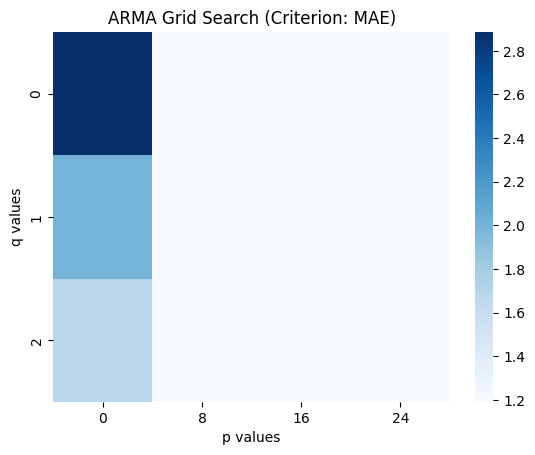

In [ ]:
sns.heatmap(mae_df, cmap = "Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterion: MAE)")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
model.plot_diagnostics(fig=fig);

In [19]:
model = ARIMA(y_train, order= (24,0,2)).fit()

y_pred = model.predict()

# Calculate training MAE
mae = mean_absolute_error(y_train, y_pred)
print(round(mae, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.18


In [20]:
model.forecast(2022-12-31)

2020-11-06 01:00:00+01:00    29.823922
2020-11-07 01:00:00+01:00    29.723045
2020-11-08 01:00:00+01:00    29.685065
2020-11-09 01:00:00+01:00    29.658734
2020-11-10 01:00:00+01:00    29.682991
                               ...    
2026-04-03 01:00:00+01:00    29.174513
2026-04-04 01:00:00+01:00    29.174513
2026-04-05 01:00:00+01:00    29.174513
2026-04-06 01:00:00+01:00    29.174514
2026-04-07 01:00:00+01:00    29.174514
Freq: D, Name: predicted_mean, Length: 1979, dtype: float64

In [21]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            UV000005502   No. Observations:                14920
Model:                ARIMA(24, 0, 2)   Log Likelihood              -27998.230
Date:                Tue, 12 Dec 2023   AIC                          56052.461
Time:                        18:07:51   BIC                          56265.554
Sample:                    01-01-1980   HQIC                         56123.180
                         - 11-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1745      0.062    467.245      0.000      29.052      29.297
ar.L1          0.6184      0.022     28.514      0.000       0.576       0.661
ar.L2          1.0004      0.034     29.730      0.0

In [22]:
model_test = ARIMA(y_test, order= (24,0,2)).fit()

y_pred_test = model_test.predict()

# Calculate training MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(round(mae_test, 2))
print(round(rmse_test, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.04
1.41


                               SARIMAX Results                                
Dep. Variable:            UV000005502   No. Observations:                  786
Model:                ARIMA(24, 0, 2)   Log Likelihood               -1383.258
Date:                Tue, 12 Dec 2023   AIC                           2822.517
Time:                        18:08:18   BIC                           2953.191
Sample:                    11-06-2020   HQIC                          2872.758
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4471      1.003     28.358      0.000      26.481      30.413
ar.L1          0.8506      0.342      2.486      0.013       0.180       1.521
ar.L2          0.3916      0.361      1.084      0.2

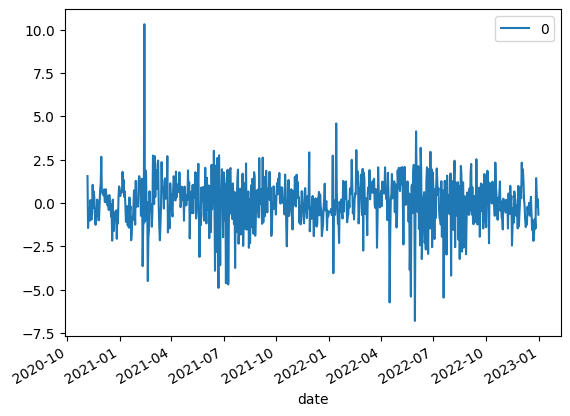

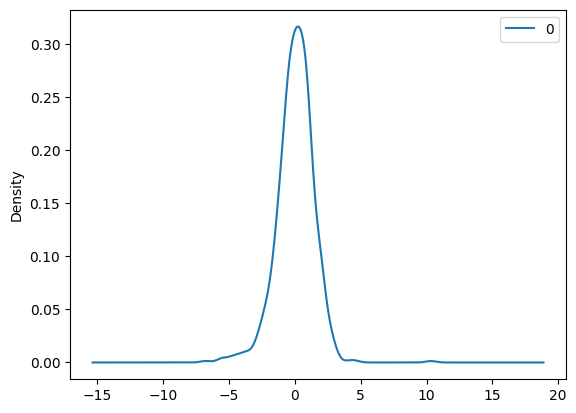

In [23]:
print(model_test.summary())
# line plot of residuals
residuals = pd.DataFrame(model_test.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

In [24]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)


In [25]:
fig = px.line(df_pred_test, labels={"value": "Air Temp."})
fig.show()

In [36]:
data_forecast = y_test.loc['2022-12-28': '2022-12-31']

len(data_forecast)

4

In [37]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(data_forecast)):
    model = ARIMA(history, order= (24,0,2)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

<ipython-input-37-a057e4b76530>:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

<ipython-input-37-a057e4b76530>:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas i

In [28]:
history

date
1980-01-01 01:00:00+01:00    23.89
1980-01-02 01:00:00+01:00    24.44
1980-01-03 01:00:00+01:00    24.44
1980-01-04 01:00:00+01:00    23.33
1980-01-05 01:00:00+01:00    23.89
                             ...  
2020-11-01 01:00:00+01:00    29.44
2020-11-02 01:00:00+01:00    28.89
2020-11-03 01:00:00+01:00    28.89
2020-11-04 01:00:00+01:00    29.44
2020-11-05 01:00:00+01:00    30.00
Name: UV000005502, Length: 14920, dtype: float64

In [38]:
y_pred_wfv

2020-11-06 01:00:00+01:00    29.823922
2020-11-07 01:00:00+01:00    29.829112
2020-11-08 01:00:00+01:00    28.842042
2020-11-09 01:00:00+01:00    28.824218
Freq: D, dtype: float64

In [46]:
y_test.loc['2020-11-06': '2020-11-10']

date
2020-11-06 01:00:00+01:00    30.00
2020-11-07 01:00:00+01:00    28.33
2020-11-08 01:00:00+01:00    28.33
2020-11-09 01:00:00+01:00    27.78
2020-11-10 01:00:00+01:00    27.22
Name: UV000005502, dtype: float64

In [47]:
test_mae = mean_absolute_error(y_test.loc['2020-11-06': '2020-11-09'], y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.81


In [50]:
df_predictions = pd.DataFrame({"forecasted data": y_test.loc['2020-11-06': '2020-11-09'], "y_pred_wfv": y_pred_wfv})
fig = px.line(df_predictions, labels = {"value": "Air Temperature"})
fig.show()

### Dealing with all the Models all at once

In [41]:
model_df.head()

,UV000005502,UV000005507,UV000005522,UV000065501,UV000065516,UVM00065503,UVM00065510,UVM00065518,IV000005557,IV000005562,...,SGM00061695,SGM00061697,SGM00061698,SGM00061699,SL000061856,LIM00065660,GHM00065472,CVM00008594,GV000001832,avg_temp
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01 01:00:00+01:00,23.89,24.44,26.67,21.67,24.44,23.33,24.44,26.67,25.56,24.44,...,23.33,26.67,28.89,30.00,26.67,27.78,26.11,21.67,26.11,24.630000
1980-01-02 01:00:00+01:00,24.44,24.44,27.22,24.44,26.11,25.00,26.11,26.67,25.56,27.22,...,24.44,26.67,27.78,26.11,26.67,27.78,28.89,22.22,26.11,25.208750
1980-01-03 01:00:00+01:00,24.44,25.00,26.11,22.78,25.00,25.56,25.00,26.67,26.11,27.22,...,23.33,26.67,28.89,27.78,26.67,27.78,28.89,21.11,26.11,25.409583
1980-01-04 01:00:00+01:00,23.33,25.00,26.11,23.33,24.44,24.44,25.00,26.67,26.67,26.67,...,21.67,26.67,23.33,28.33,26.67,27.78,28.89,21.67,26.11,25.547778
1980-01-05 01:00:00+01:00,23.89,25.56,27.22,23.89,25.56,25.56,26.67,26.67,26.11,26.67,...,24.44,26.67,23.33,27.22,26.67,27.78,28.89,21.67,26.11,25.339583


In [42]:
# Check for Stationality using ADF to confirm if differencing is required or not

columns = model_df.columns

for station in columns:
  y = model_df[station]
  # Check for Adf test
  result = adfuller(y)
  print(station)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

UV000005502
ADF Statistic: -14.608482
p-value: 0.000000
UV000005507
ADF Statistic: -13.597260
p-value: 0.000000
UV000005522
ADF Statistic: -12.677597
p-value: 0.000000
UV000065501
ADF Statistic: -14.058749
p-value: 0.000000
UV000065516
ADF Statistic: -13.461369
p-value: 0.000000
UVM00065503
ADF Statistic: -14.865656
p-value: 0.000000
UVM00065510
ADF Statistic: -12.790538
p-value: 0.000000
UVM00065518
ADF Statistic: -12.341820
p-value: 0.000000
IV000005557
ADF Statistic: -10.318544
p-value: 0.000000
IV000005562
ADF Statistic: -11.306980
p-value: 0.000000
IV000005592
ADF Statistic: -9.152275
p-value: 0.000000
IV000065585
ADF Statistic: -9.867955
p-value: 0.000000
IV000065599
ADF Statistic: -9.535234
p-value: 0.000000
IVM00065545
ADF Statistic: -9.441641
p-value: 0.000000
IVM00065560
ADF Statistic: -9.491261
p-value: 0.000000
IVM00065563
ADF Statistic: -10.416192
p-value: 0.000000
IVM00065578
ADF Statistic: -10.556275
p-value: 0.000000
IVM00065594
ADF Statistic: -8.777393
p-value: 0.00000

In [43]:
# Create a function for the modeling and return the Accuracy Metrics

def ARIMA_model(station):
  y = model_df[station]
  # Check for Adf test
  result = adfuller(y)
  print(station)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

  # Split the data into train-test split with 90% train data
  cutoff_test = int(len(y) * 0.95)

  y_train = y.iloc[:cutoff_test]
  y_test = y.iloc[cutoff_test:]

  # Build a Baseline Model with train data
  y_train_mean = y_train.mean()
  y_pred_baseline = [y_train_mean] * len(y_train)
  mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
  rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_baseline))
  print("Mean Temperatrure Reading:", round(y_train_mean, 2))
  print("Baseline MAE:", round(mae_baseline, 2))
  print("Baseline RMSE:", round(rmse_baseline, 2))

  # Build an ARIMA model with train test. Confirm the ARIMA p and q parameters with hyperparameter tuning
  # This was done using only one station
  model = ARIMA(y_train, order= (24,0,2)).fit()

  y_pred = model.predict()
  # Calculate training MAE and RMSE
  mae = mean_absolute_error(y_train, y_pred)
  rmse = np.sqrt(mean_squared_error(y_train, y_pred))
  print("Mean Absolute Error: ", round(mae, 2))
  print("Root Mean Squared Error: ", round(rmse, 2))
  print(model.summary())

In [44]:
ARIMA_model('GV000001832')

GV000001832
ADF Statistic: -9.836503
p-value: 0.000000
Mean Temperatrure Reading: 27.2
Baseline MAE: 1.19
Baseline RMSE: 1.46


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Mean Absolute Error:  0.59
Root Mean Squared Error:  0.87
                               SARIMAX Results                                
Dep. Variable:            GV000001832   No. Observations:                14920
Model:                ARIMA(24, 0, 2)   Log Likelihood              -19010.072
Date:                Tue, 12 Dec 2023   AIC                          38076.145
Time:                        19:24:20   BIC                          38289.237
Sample:                    01-01-1980   HQIC                         38146.864
                         - 11-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1683      0.134    202.434      0.000      26.905      27.431
ar.L1          0.4897      0.091      5.402      0.000       0.312       